# Plagiarism Evaluation

The approach is as follows:

1. Detect the key terms from the test text
2. Identify top candidates from our Corpus with similar key terms
3. Create a Knowledge Graph of the related labels for the candidates and test text
4. Compare the similarity between the knowledge graphs for key term relations 

In [ ]:
import os
import pandas as pd
import numpy as np
import ast

In [31]:
related_terms_sent_path = '../related_terms_sent.csv'
related_terms_sent_df = pd.read_csv(related_terms_sent_path)

In [32]:
print(len(related_terms_sent_df))

29014


In [33]:
import pandas as pd
import ast
from collections import Counter

In [99]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [97]:
import networkx as nx
from IPython.core.display import display, HTML
!pip install pyvis
from pyvis.network import Network
import matplotlib.pyplot as plt

/tmp/ipykernel_18909/3900105394.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Knowledge Graph pre-processing

In [34]:
def remove_single_letters_and_filter(df, column_name, min_count=2):
    """
    Remove single-letter items and filter items based on frequency in a DataFrame column.

    This function processes a column in a DataFrame, removing single-letter items and
    filtering out items that occur less than a specified minimum count. It handles both
    string representations of lists and actual lists.

    Args:
    df (pandas.DataFrame): The DataFrame to process.
    column_name (str): The name of the column to process.
    min_count (int, optional): The minimum count for an item to be kept. Defaults to 2.

    Returns:
    tuple: A tuple containing:
        - unique_count_before (int): Number of unique items before filtering.
        - unique_count_after (int): Number of unique items after filtering.
        - sorted_counts (list): List of tuples (item, count) sorted by count.
        - df (pandas.DataFrame): The processed DataFrame.
    """
    def flatten(lst):
        for item in lst:
            if isinstance(item, list):
                yield from flatten(item)
            else:
                yield item
    
    if df[column_name].dtype == 'object' and isinstance(df[column_name].iloc[0], str):
        df[column_name] = df[column_name].apply(lambda x: list(flatten(ast.literal_eval(x))))
    
    df[column_name] = df[column_name].apply(lambda x: [item for item in x if len(str(item)) > 1])
    
    all_items_before = [item for sublist in df[column_name] for item in sublist]
    counts_before = Counter(all_items_before)
    unique_count_before = len(counts_before)
    
    items_to_keep = {item for item, count in counts_before.items() if count >= min_count}
    
    df[column_name] = df[column_name].apply(lambda x: [item for item in x if item in items_to_keep])
    
    all_items_after = [item for sublist in df[column_name] for item in sublist]
    counts_after = Counter(all_items_after)
    unique_count_after = len(counts_after)
    
    sorted_counts = sorted(counts_after.items(), key=lambda x: x[1])
    
    return unique_count_before, unique_count_after, sorted_counts, df

unique_before, unique_after, result, related_terms_sent_df = remove_single_letters_and_filter(related_terms_sent_df, 'entities', min_count=2)
print(f"Number of unique values before filtering: {unique_before}")
print(f"Number of unique values after filtering: {unique_after}")

Number of unique values before filtering: 9358
Number of unique values after filtering: 5311


In [38]:
# Remove single-letter items and items matching the regex pattern
pattern = re.compile(r'^\d{1,3}\-\d{1,2}.*')
related_terms_sent_df['entities'] = related_terms_sent_df['entities'].apply(lambda x: [item for item in x if len(str(item)) > 1 and not pattern.match(str(item))])

In [42]:
relative_path = '../../siads_capstone/'
    
absolute_path = os.path.abspath(relative_path)
    
related_terms_filtered_file_name = "related_terms_sent_filtered.csv"
    
related_terms_filtered_file_name_file_path = os.path.join(absolute_path, related_terms_filtered_file_name)

related_terms_sent_df.to_csv(related_terms_filtered_file_name_file_path, index=False)

print(f"unique related terms (>1 character long, >2 unique value count, numerical) has been removed and saved as '{related_terms_filtered_file_name}' in the following directory:")
print(absolute_path)

unique related terms (>1 character long, >2 unique value count, numerical) has been removed and saved as 'related_terms_sent_filtered.csv' in the following directory:
/home/sagemaker-user/siads_capstone


In [182]:
related_terms_sent_path = '../related_terms_sent_filtered.csv'
related_terms_sent_df = pd.read_csv(related_terms_sent_path)

## Create Knowledge Graphs

In [183]:
df = related_terms_sent_df

filtered_df = df[(df['title'] == 'cluster analysis') & (df['h2'] == 'Introduction')].reset_index(drop=True)
filtered_df2 = df[(df['title'] == 'k-nearest neighbors algorithm') & (df['h2'] == 'Introduction')].reset_index(drop=True)

In [184]:
def create_text_graph(df, window_size=3):
    """
    Create a graph representation of text based on entity co-occurrences within a sliding window.

    This function processes a DataFrame containing entities for each sentence,
    creating weighted relationships between entities that occur within the same window.
    The weight of each relationship is inversely proportional to the distance between entities.

    Args:
    df (pandas.DataFrame): DataFrame containing an 'entities' column with lists of entities for each sentence.
    window_size (int, optional): Size of the sliding window in sentences. Defaults to 3.

    Returns:
    pandas.DataFrame: A DataFrame representing the graph, with columns 'source', 'target', and 'weight'.
                      Each row represents a relationship between two entities.
    """
    relationships = []
    for i in range(len(df) - window_size + 1):
        end_i = i + window_size
        entity_lists = [ast.literal_eval(entities) for entities in df.loc[i:end_i, 'entities']]
        for window_idx, entities in enumerate(entity_lists):
            for entity1 in entities:
                for future_idx in range(window_idx, len(entity_lists)):
                    for entity2 in entity_lists[future_idx]:
                        if entity1 != entity2:
                            weight = 1 / (future_idx - window_idx + 1)
                            relationships.append({"source": entity1, "target": entity2, "weight": weight})
    
    relationships_df = pd.DataFrame(relationships)
    if not relationships_df.empty:
        relationships_df[['source', 'target']] = np.sort(relationships_df[['source', 'target']], axis=1)
        relationships_df = relationships_df.groupby(["source", "target"], sort=False, as_index=False)['weight'].sum()
    
    return relationships_df

relationship_df = create_text_graph(filtered_df)
relationship_df2 = create_text_graph(filtered_df2)


## Comparative Knowledge Graph Evaluation Techniques 

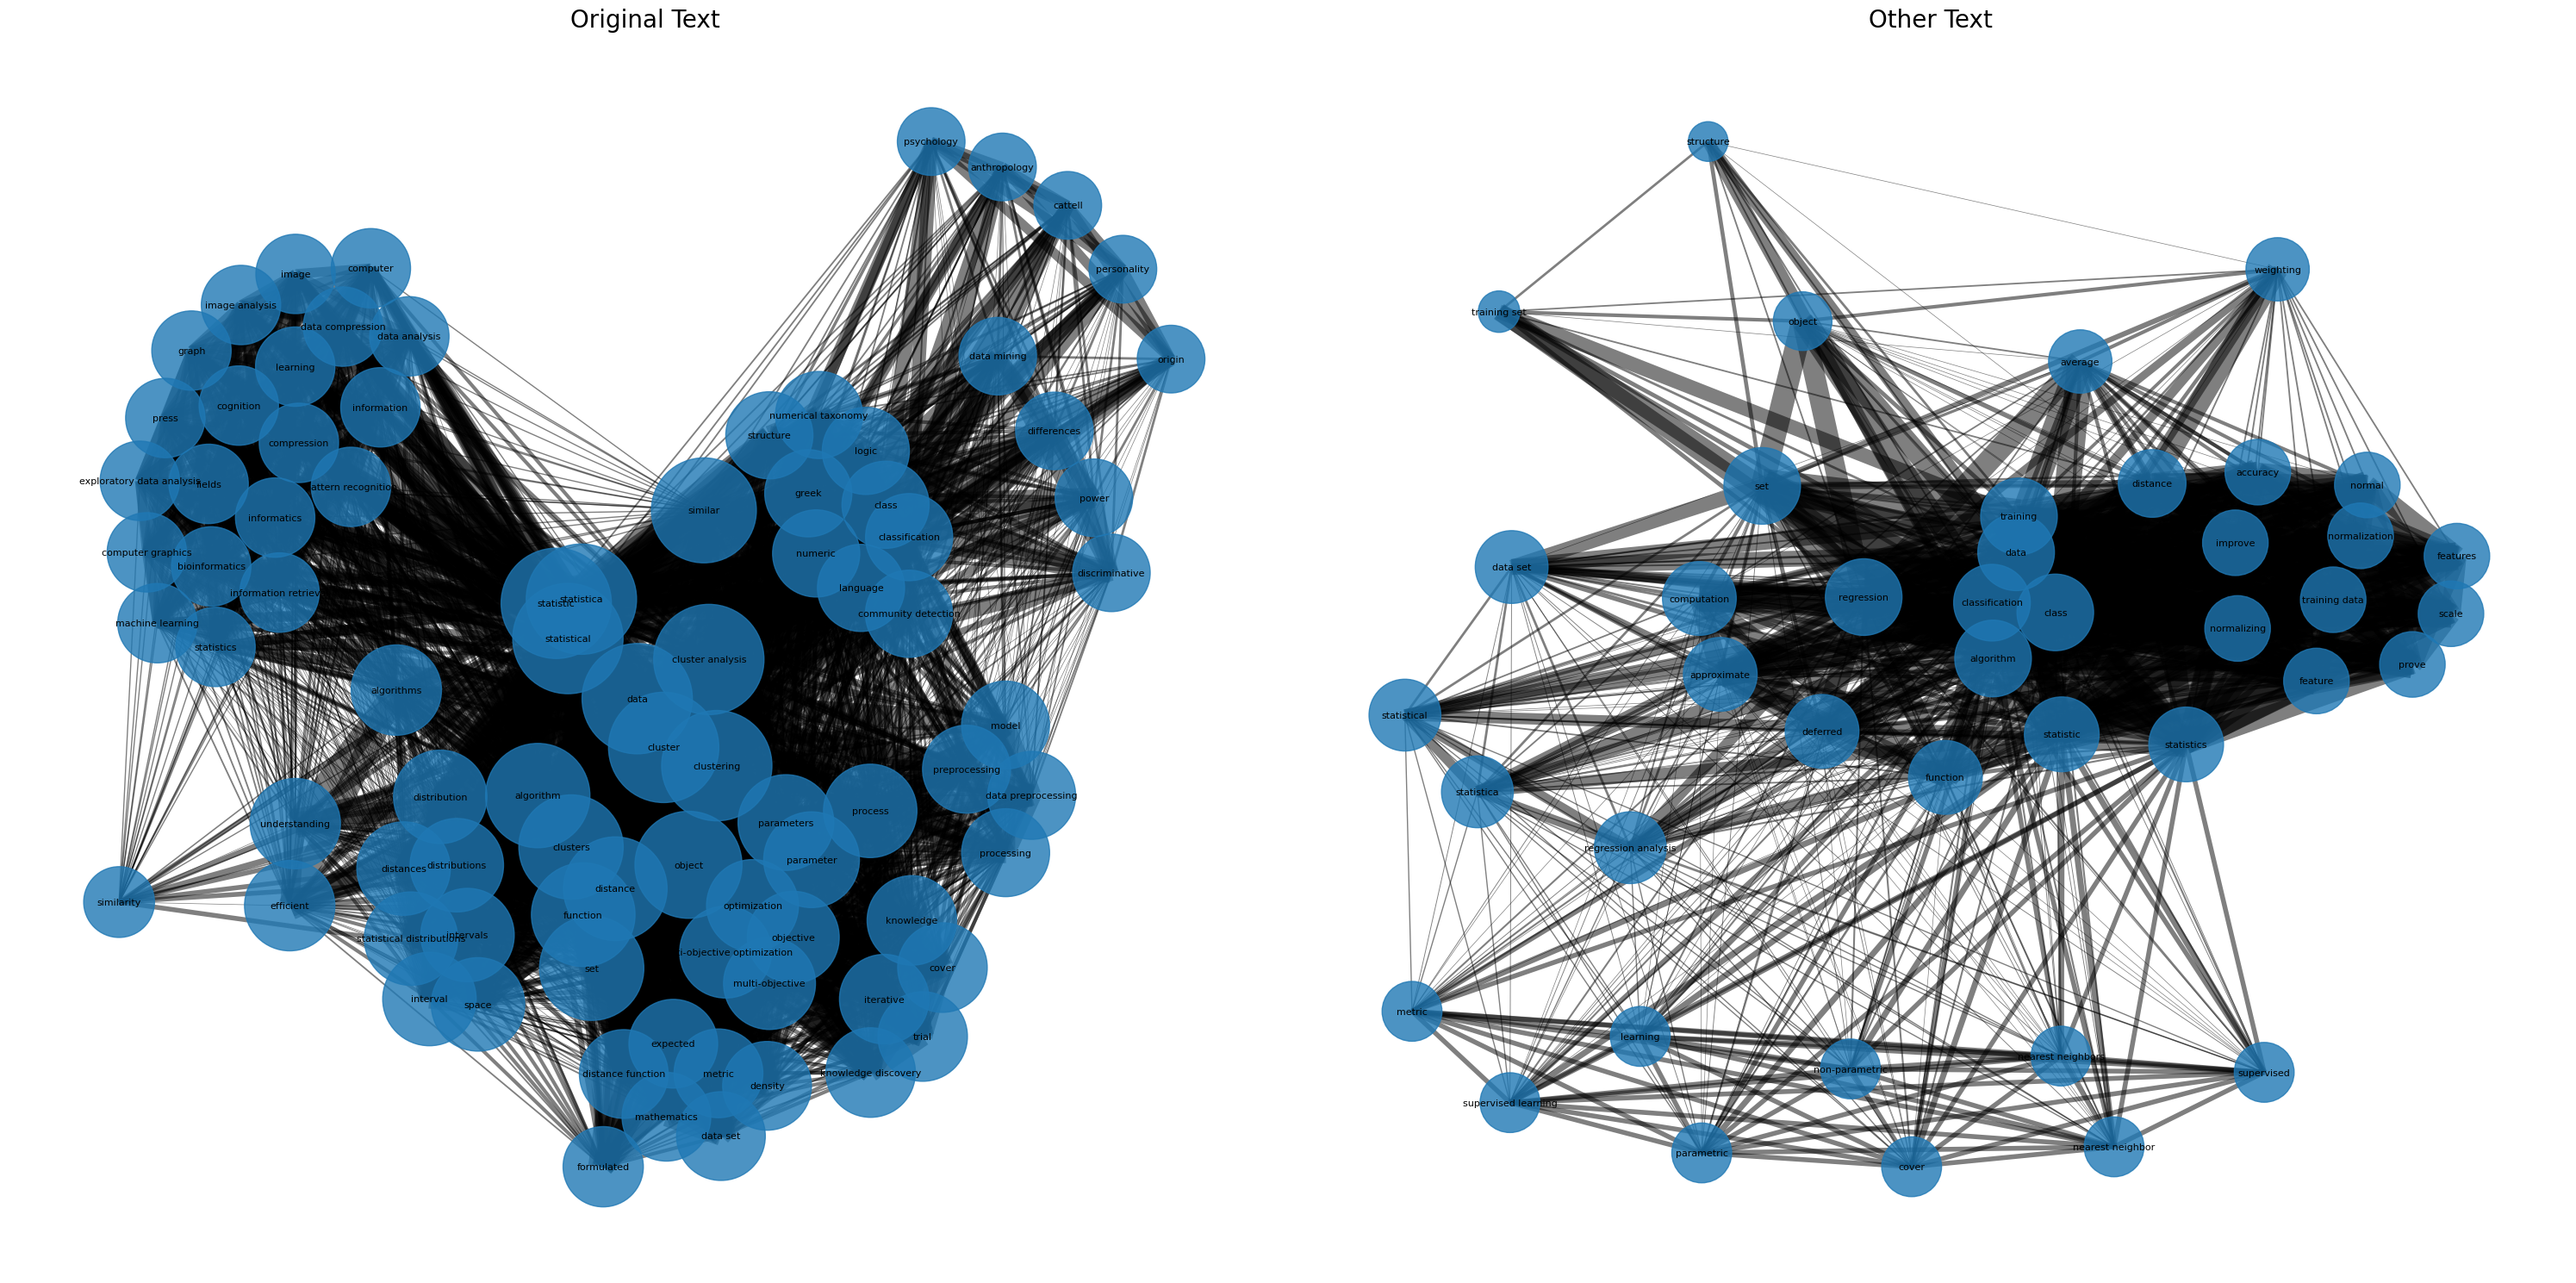

In [185]:
def plot_relationship_graphs(*dataframes, titles=None):
    """
    Plot relationship graphs for one or two DataFrames.

    This function creates network visualizations of relationship data,
    where nodes represent entities and edges represent relationships between them.
    Node sizes are based on degree centrality, and edge widths are based on relationship weights.

    Args:
    *dataframes: One or two pandas DataFrames containing relationship data.
                 Each DataFrame should have 'source', 'target', and 'weight' columns.
    titles (list, optional): List of titles for the graphs. If not provided,
                             default titles will be used.

    Raises:
    ValueError: If the number of input DataFrames is not 1 or 2.

    Returns:
    None: The function displays the plot(s) but does not return any value.
    """
    if len(dataframes) not in [1, 2]:
        raise ValueError("This function accepts either one or two DataFrames.")
    
    fig, axes = plt.subplots(1, len(dataframes), figsize=(15*len(dataframes), 15))
    if len(dataframes) == 1:
        axes = [axes]
    
    for i, df in enumerate(dataframes):
        G = nx.from_pandas_edgelist(df, source="source", target="target", edge_attr="weight", create_using=nx.Graph())
        
        degree_dict = dict(G.degree())
        nx.set_node_attributes(G, degree_dict, 'size')
        
        edge_width = [G[u][v]['weight'] * 2 for u, v in G.edges()]
        
        pos = nx.spring_layout(G, k=0.5, iterations=50)
        
        nx.draw_networkx_nodes(G, pos, ax=axes[i], node_size=[v * 100 for v in degree_dict.values()], alpha=0.8)
        nx.draw_networkx_edges(G, pos, ax=axes[i], width=edge_width, alpha=0.5)
        nx.draw_networkx_labels(G, pos, ax=axes[i], font_size=8, font_family='sans-serif')
        
        if titles and len(titles) > i:
            axes[i].set_title(titles[i], fontsize=20)
        else:
            axes[i].set_title(f"Keyword Relationship Graph {i+1}", fontsize=20)
        
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_relationship_graphs(relationship_df, relationship_df2, titles=["Original Text", "Other Text"])

In [ ]:
def visualize_graph_overlap(graph1, graph2, title1, title2):
    """
    Visualize the overlap between two graphs and compute overlap statistics.

    This function creates a combined visualization of two graphs, highlighting
    overlapping and unique nodes and edges. It also computes and prints
    node and edge overlap statistics.

    Args:
    graph1 (pandas.DataFrame): First graph data with 'source', 'target', and 'weight' columns.
    graph2 (pandas.DataFrame): Second graph data with 'source', 'target', and 'weight' columns.
    title1 (str): Title for the first graph.
    title2 (str): Title for the second graph.

    Returns:
    None: The function displays the plot and prints overlap statistics.
    """
    G1 = nx.from_pandas_edgelist(graph1, 'source', 'target', 'weight')
    G2 = nx.from_pandas_edgelist(graph2, 'source', 'target', 'weight')

    nodes1, nodes2 = set(G1.nodes()), set(G2.nodes())
    edges1, edges2 = set(G1.edges()), set(G2.edges())
    overlapping_nodes = nodes1.intersection(nodes2)
    unique_nodes1, unique_nodes2 = nodes1 - nodes2, nodes2 - nodes1
    overlapping_edges = edges1.intersection(edges2)
    unique_edges1, unique_edges2 = edges1 - edges2, edges2 - edges1

    G_combined = nx.compose(G1, G2)

    plt.figure(figsize=(20, 20))
    pos = nx.spring_layout(G_combined, k=0.5, iterations=50)

    nx.draw_networkx_nodes(G_combined, pos, nodelist=overlapping_nodes, node_color='yellow', node_size=500, alpha=0.8, label='Overlapping Nodes')
    nx.draw_networkx_nodes(G_combined, pos, nodelist=unique_nodes1, node_color='red', node_size=300, alpha=0.8, label=f'Unique to {title1}')
    nx.draw_networkx_nodes(G_combined, pos, nodelist=unique_nodes2, node_color='blue', node_size=300, alpha=0.8, label=f'Unique to {title2}')

    nx.draw_networkx_edges(G_combined, pos, edgelist=overlapping_edges, edge_color='green', width=2, alpha=0.6, label='Overlapping Edges')
    nx.draw_networkx_edges(G_combined, pos, edgelist=unique_edges1, edge_color='red', width=1, alpha=0.4, label=f'Unique to {title1}')
    nx.draw_networkx_edges(G_combined, pos, edgelist=unique_edges2, edge_color='blue', width=1, alpha=0.4, label=f'Unique to {title2}')

    nx.draw_networkx_labels(G_combined, pos, font_size=8, font_family='sans-serif')

    plt.legend()
    plt.title(f"Graph Overlap: {title1} vs {title2}", fontsize=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print(f"Node Overlap: {len(overlapping_nodes) / len(nodes1.union(nodes2)):.2f}")
    print(f"Edge Overlap: {len(overlapping_edges) / len(edges1.union(edges2)):.2f}")

visualize_graph_overlap(graph1, graph2, "Original Text", "Other Text")

In [54]:
relative_path = '../../siads_capstone/'
    
absolute_path = os.path.abspath(relative_path)
    
relationship_df_file_name = "relationship_df_filtered.csv"
    
relationship_df_file_path = os.path.join(absolute_path, relationship_df_file_name)

relationship_df.to_csv(relationship_df_file_path, index=False)

print(f"unique relationship with source, targets has been saved as '{relationship_df_file_name}' in the following directory:")
print(absolute_path)

unique relationship with source, targets has been saved as 'relationship_df_filtered.csv' in the following directory:
/home/sagemaker-user/siads_capstone
